# MLE exponential fit
The following notebook shows how to compute the parameters of a single and a double exponential fit of a histogram of residence times of enzymes. This is used to calculate the rate constant koff of the enzymes. 
We show that a single exponential does not fully describe the data but a double does.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy.optimize import minimize
from scipy.stats import chi2
from scipy.special import gammaln
from scipy.stats import chisquare
from scipy.stats import norm
import numdifftools as ndt

In [2]:
# File path
filename = r'C:\Users\emily\Locs.csv'
fname = r'C:\Users\emily\\'
OutName = 'DoubleMLE'

# Read the data using pandas
data = pd.read_csv(filename)

# Binning and timescale
binning = 4  # If data are 4 times binned
timescale = 2  # To convert to seconds

# Extract data and set conditions
residenceTime_Cy5 = data.loc[
    (data['TRACK_STOP'] < 999) & (data['TRACK_START'] > 100),
    'TRACK_DURATION'] * timescale

# Calculate the number of data points
N = len(residenceTime_Cy5)
#print(N) 

In [3]:
# Single exponential doesn't fit well
tauMLE = np.mean(residenceTime_Cy5)

# Function for single exponential
def singleExp(x, mu):
    return (1 / mu) * np.exp(-x / mu)

# MLE with custom function
result = minimize(lambda mu: -np.sum(np.log(singleExp(residenceTime_Cy5, mu))), x0=[30])
phatExpSingle = result.x[0]
sigma_tau = np.sqrt(result.hess_inv[0][0])


# We need the histogram
Nbins = np.arange(0, residenceTime_Cy5.max(),43)
plt.figure(figsize=(10, 6))
h1 = plt.hist(residenceTime_Cy5, bins=Nbins, facecolor=[0, 0.4470, 0.7410],linestyle='solid',edgecolor = 'black', alpha=0.7)
plt.close()

# Calculate expected counts
binEdges = h1[1]
binCenters = binEdges[:-1] + np.diff(binEdges) / 2
expectedCounts = N * (expon.cdf(binEdges[1:], scale=tauMLE) - expon.cdf(binEdges[:-1], scale=tauMLE))
sigmaCounts = np.sqrt(expectedCounts)

Chi-squared stat (Single Exp): 266.8750524612784
p-value (Single Exp): 2.9658925102639533e-46
Single Exp Fit:
mu = 57.57 ± 1.18
p-value = 0.0000


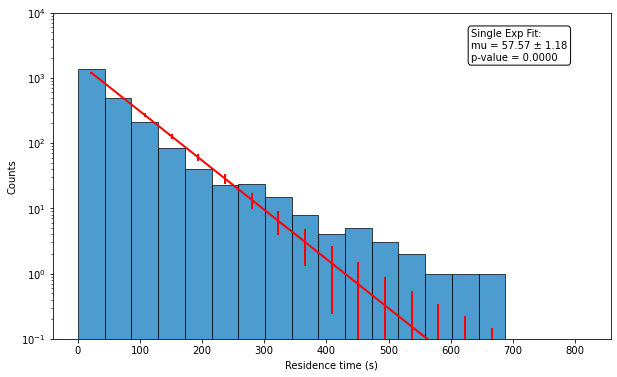

In [4]:
# We plot them together
Nbins = np.arange(0, residenceTime_Cy5.max(), 43)
plt.figure(figsize=(10, 6))
h1 = plt.hist(residenceTime_Cy5, bins=Nbins, facecolor=[0, 0.4470, 0.7410], linestyle='solid', edgecolor='black', alpha=0.7)

# Bin centers
binEdges = h1[1]
binCenters = binEdges[:-1] + np.diff(binEdges) / 2
expectedCounts = N * (expon.cdf(binEdges[1:], scale=tauMLE) - expon.cdf(binEdges[:-1], scale=tauMLE))
sigmaCounts = np.sqrt(expectedCounts)

# Plot expected number of counts with error bars
plt.errorbar(binCenters, expectedCounts, yerr=sigmaCounts, fmt='r-', linewidth=2)
plt.yscale('log')
plt.xlabel('Residence time (s)')
plt.ylabel('Counts')
plt.ylim([0.1, 1e4])


#For p value of fit
def calculate_expected_frequencies_single(cdf_function, data, bin_edges):
    cdf_values = cdf_function(bin_edges, scale=tauMLE)
    expected_frequencies = np.diff(cdf_values) * len(data)
    return expected_frequencies

# Calculate the expected frequencies using the fitted CDF for single exponential
expected_freq_single = calculate_expected_frequencies_single(expon.cdf, residenceTime_Cy5, binEdges)
# Calculate the observed frequencies from the data
observed_freq_single, _ = np.histogram(residenceTime_Cy5, bins=Nbins)

# Perform the chi-squared test for single exponential
chi_stat_single, p_value_single = chisquare(f_obs=observed_freq_single, f_exp=expected_freq_single)

# Print the p-value
print(f"Chi-squared stat (Single Exp): {chi_stat_single}")
print(f"p-value (Single Exp): {p_value_single}")

# Annotating the plot with fit results
fit_results_text = (
    f"Single Exp Fit:\n"
    f"mu = {tauMLE:.2f} ± {sigma_tau:.2f}\n"
    f"p-value = {p_value_single:.4f}"
)
print(fit_results_text)
plt.annotate(fit_results_text, xy=(0.75, 0.95), xycoords='axes fraction', 
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.show()


In [5]:
# MLE fit to data with double-exponential
def doubleExp(x, mu1, mu2, W):
    return W * (1 / mu1) * np.exp(-x / mu1) + (1 - W) * (1 / mu2) * np.exp(-x / mu2)

def neg_log_likelihood(params):
    mu1, mu2, W = params
    likelihood = doubleExp(residenceTime_Cy5, mu1, mu2, W)
    likelihood[likelihood == 0] = 1e-10  # Avoid log of zero
    return -np.sum(np.log(likelihood))

initial_params = [100, 50, 0.5]  # Adjust these based on your data or try different values

result = minimize(neg_log_likelihood, initial_params, method='Nelder-Mead')
## calculating errors from hessian matrix using numdifftools
Hfun = ndt.Hessian(neg_log_likelihood, full_output=True)
hessian_ndt, info = Hfun(result.x)
hess_inv=np.linalg.inv(hessian_ndt)

if result.success:
    mu1_fit, mu2_fit, W_fit = result.x
    print("Optimization successful. Fitted parameters:", result.x)
else:
    print("Optimization failed:", result.message)
    mu1_fit, mu2_fit, W_fit = [np.nan, np.nan, np.nan]

# Calculate the covariance matrix of the fitted parameters
acov_double = hess_inv
sigma_mu1 = np.sqrt(acov_double[0, 0])
sigma_mu2 = np.sqrt(acov_double[1, 1])

# print("sigma_mu1", sigma_mu1)
# print("sigma_mu2", sigma_mu2)
# print("mu1_fit", mu1_fit)
# print("mu2_fit", mu2_fit)
# print("W_fit", W_fit)

def fittedDoubleCDF(t):
    return W_fit * (1 - np.exp(-t / mu1_fit)) + (1 - W_fit) * (1 - np.exp(-t / mu2_fit))

Optimization successful. Fitted parameters: [1.54160636e+02 4.63764205e+01 1.03890620e-01]


20
Double Exp Fit:
mu1 = 154.16 ± 20.96
mu2 = 46.38 ± 1.69
p-value = 0.2519


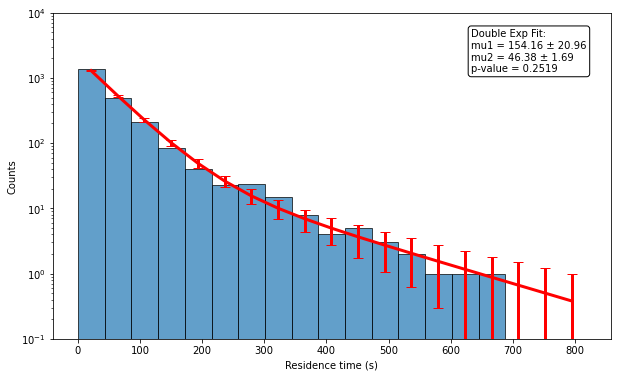

In [6]:
# Do some plotting:
Nbins=np.arange(0, residenceTime_Cy5.max(),43) 
print(len(Nbins))
fig, ax = plt.subplots(figsize=(10, 6))
h2, binEdges, _ = ax.hist(residenceTime_Cy5, bins=Nbins,linestyle='solid',edgecolor = 'black', alpha=0.7)
ax.set_yscale("log")
# Corrected expected counts calculation for double exponential
expectedCountsDouble = N * (
    W_fit * (expon.cdf(binEdges[1:], scale=mu1_fit) - expon.cdf(binEdges[:-1], scale=mu1_fit)) 
    + (1 - W_fit) * (expon.cdf(binEdges[1:], scale=mu2_fit) - expon.cdf(binEdges[:-1], scale=mu2_fit))
)

sigmaCountsDouble = np.sqrt(expectedCountsDouble)

#For p value of fit
def calculate_expected_frequencies(cdf_function, data, bin_edges):
    cdf_values = cdf_function(bin_edges)
    expected_frequencies = np.diff(cdf_values) * len(data)
    return expected_frequencies, bin_edges
# Calculate the expected frequencies using the fitted CDF
expected_freq, bin_edges = calculate_expected_frequencies(fittedDoubleCDF, residenceTime_Cy5, binEdges)
# Calculate the observed frequencies from the data
observed_freq, _ = np.histogram(residenceTime_Cy5, bins=Nbins)
# Perform the chi-squared test
chi_stat, pDouble = chisquare(f_obs=observed_freq, f_exp=expected_freq)
# print("expected_freq", expected_freq)
# print("observed_freq", observed_freq)

    
# Plotting the histogram and the expected counts for double exponential
ax.errorbar(binEdges[:-1]+21, expectedCountsDouble, yerr=sigmaCountsDouble, fmt='r-', linewidth=3, solid_capstyle='projecting', capsize=5)
ax.set_yscale('log')
ax.set_xlabel('Residence time (s)')
ax.set_ylabel('Counts')
ax.set_ylim(0.1, 1e4)

# Annotating the plot with fit results
fit_results_text = (
    f"Double Exp Fit:\n"
    f"mu1 = {mu1_fit:.2f} ± {sigma_mu1:.2f}\n"
    f"mu2 = {mu2_fit:.2f} ± {sigma_mu2:.2f}\n"
   f"p-value = {pDouble:.4f}"

)
print(fit_results_text)
ax.annotate(fit_results_text, xy=(0.75, 0.95), xycoords='axes fraction', 
            verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

#plt.savefig(fname + 'MLE_double_exp.pdf', format='pdf')
#plt.close()

# Saving fitted parameters
params_new = [mu1_fit, mu2_fit, sigma_mu1, sigma_mu2, W_fit]
headers = ['mu1_fit', 'mu2_fit', 'sigma_mu1', 'sigma_mu2', 'W_fit']
np.savetxt(fname + 'FittingParams.csv', params_new, delimiter=',', header=','.join(headers), comments='')